In [1]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)
import evaluation.evaluate as evaluate

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o026_f32/"

In [3]:
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset)
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset)  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset)

inputShape = X_train[0].shape

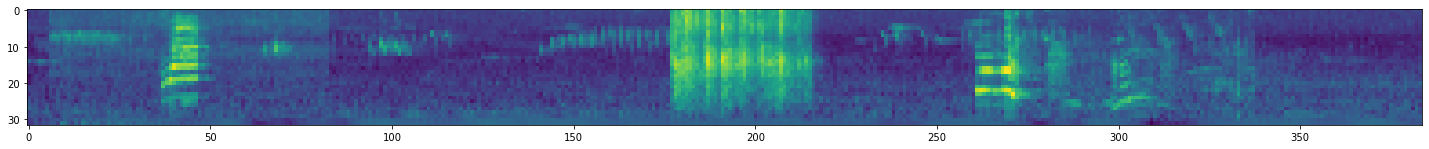

In [12]:
plt.figure(figsize=(25,5))
plt.imshow(np.rot90(X_train[3]))

In [27]:
X_challenge, timepoints, challengeFileList = bbdc.load_challenge_data("challenge_filelist_dummy.csv", pathToDataset)
inputShape = X_challenge[0].shape

In [ ]:
print(tf.__version__)
print(X_train.shape)

In [13]:
channels = [32, 64, 90]
model = unet.u_net(inputShape, channels, lessParameter = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 32)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 384, 32)      1056        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 384, 32)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
#Mit crossentropy
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train,Y_train, batch_size=15, epochs=100, validation_data=(X_validation, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/100
534/534 [==============================] - 50s 57ms/step - loss: 1.4414 - mae: 0.0872 - accuracy: 0.6113 - val_loss: 0.8493 - val_mae: 0.0567 - val_accuracy: 0.7503

Epoch 00001: val_loss improved from inf to 0.84932, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 11s 20ms/step - loss: 0.7842 - mae: 0.0502 - accuracy: 0.7662 - val_loss: 0.7460 - val_mae: 0.0475 - val_accuracy: 0.7819

Epoch 00002: val_loss improved from 0.84932 to 0.74600, saving model to model.h5
Epoch 3/100
534/534 [==============================] - 10s 20ms/step - loss: 0.6670 - mae: 0.0433 - accuracy: 0.8028 - val_loss: 0.6058 - val_mae: 0.0386 - val_accuracy: 0.8227

Epoch 00003: val_loss improved from 0.74600 to 0.60583, saving model to model.h5
Epoch 4/100
534/534 [==============================] - 10s 20ms/step - loss: 0.5911 - mae: 0.0387 - accuracy: 0.8257 - val_loss: 0.5767 - val_mae: 0.0371 - val_accuracy: 0.8320

Epoch 00004: val_loss improved from 0.60583 to 0.

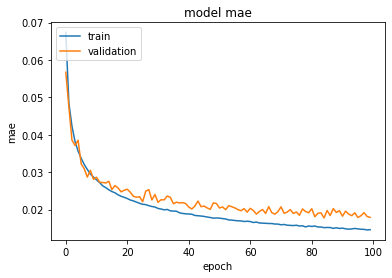

In [16]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

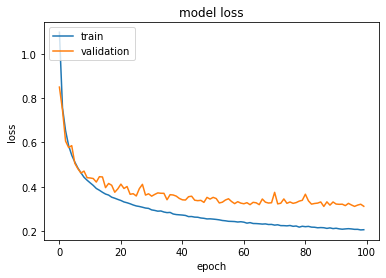

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

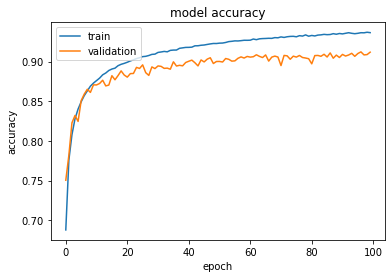

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
#model = keras.models.load_model("Modelle_Jannes/")
prediction = model.predict(X_test)

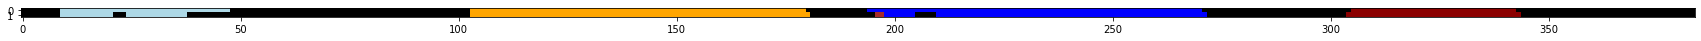

In [20]:
bbdc.plotPredictionAndGT(Y_test, prediction, 1)

In [21]:
scores = model.evaluate(X_test, Y_test)


32/32 [==============================] - 0s 10ms/step - loss: 0.2894 - mae: 0.0172 - accuracy: 0.9171


In [22]:
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_mel_test.csv", index=False)
df.head()
evaluate.evaluate("../predictions/jannes/LP1d_Prediction_mel_test.csv", "./../data/test.csv")

(0.1311456485985775, 'Valid file')

In [23]:
postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_mel_pp_test.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_mel_pp_test.csv", "./../data/test.csv"))

(0.8627705303433626, 'Valid file')


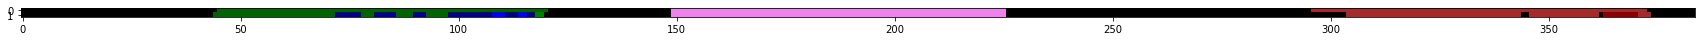

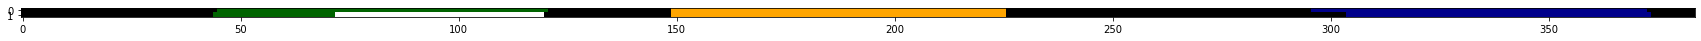

In [24]:
index = 0
bbdc.plotPredictionAndGT(Y_test, prediction, index) #TODO Problem mit falscher Farbdarstellung lösen
bbdc.plotPredictionAndGT(Y_test, postProcessedPrediction, index)

# Evaluation mit Validationset

In [25]:
prediction = model.predict(X_validation)
discretePrediction = (prediction == prediction.max(axis=1)[:,None]).astype(int)
model.evaluate(X_validation, Y_validation)
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_val.csv", "./../data/validation.csv"))

postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_pp_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_pp_val.csv", "./../data/validation.csv"))

32/32 [==============================] - 0s 10ms/step - loss: 0.3118 - mae: 0.0179 - accuracy: 0.9119
(0.10671975887168393, 'Valid file')
(0.8564091127358349, 'Valid file')


# Prediction der Challenge

In [28]:
#model = keras.models.load_model("Modelle_Jannes/model9561.h5")
prediction = model.predict(X_challenge)
postProcessedPredictionChallenge = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPredictionChallenge, timepoints, challengeFileList, calculateProbs=True)
df.to_csv("../predictions/jannes/LP1d_PredictionChallenge_mel_probs.csv", index=False)

/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
